## Vlasov equations

We want to solve Vlosov equations on 1  (in $S^1$).

The equations are: 

\begin{align}
\partial_t f + p \partial_x f &= \frac{q}{m}E \partial_p f \\
\partial_t E = -4\pi J \\
\partial_x E = 4\pi \rho \\
\end{align}

Where $f = f(t,x,p)$ is a distribution function in phase espace. 
Note that the invarian volume element is, 

$$
dP = dp_x/p_0
$$ 

We define, the particle number with respect to an observer with four-velocity $u^a$,

$$
N = \int f(x,p)(-u \cdot p)\; dP
$$ 

Thus, for the observer at rest in the coordinate system $(t,x)$ we get

$$
N = \int f(x,p) p_0 \; dP = \int f(x,p) \; dp_x
$$ 

Otherwise one has the four-vector particle density,

$$
N^a = \int f(x,p) p^a \; dP = \int f(x,p) \frac{p^a}{p_0} \; dp_x
$$

Thus, 

$$
N^x = \int f(x,p) \frac{p_x}{p_0} \; dp_x
$$

Likewise we have the energy-momentum tensor,

$$
T^{ab} = \int p^a p^b f(x,p) dP 
$$

So, 

$$
T^{00} = \int p^0 f(x,p) dp_x = m \int \sqrt{1 + p^2/m^2} dp
$$




\begin{align}
\rho(t,x) &:= q\int f(t,x,p) \; dp - n_0 \\
n_0 &:= q \int \int f(t,x,p) \; dp \; dx / V\\
J(t,x) &:= q \int v f(t,x,p) \; dp, \\
v &:= \frac{\frac{p}{m}}{\sqrt{1 + \frac{p^2}{m^2}}} \\ 
\end{align}

And $E = E(t,x)$ is the electric field.


The equilibrium distribution function is: 

$$
f(\gamma) = \frac{\gamma^2 \beta}{\theta K_2(\frac{1}{\theta})}\; e^{-\frac{\gamma}{\theta}} \;\;\;\; \gamma = \frac{1}{\sqrt{1 - \beta^2}}
$$ 

or

$$
f(p) = \frac{1}{4\pi m^3 c^3 \theta K_2(\frac{1}{\theta})} \; e^{-\frac{\gamma(p)}{\theta}} \;\;\;\;\; \gamma(p) = \sqrt{1 + (\frac{p}{m})^2}
$$

and $K_2$ is the Bessel function of second kind.

In [2]:
using Plots
using Statistics
using FFTW
FFTW.set_provider!("mkl")
#import Pkg; Pkg.add("FileIO")
using FileIO
using Base.Threads
using Distributions
#Pkg; Pkg.add("DistributedArrays")
println("nthreads = $(nthreads())")

nthreads = 1


In [56]:
include("aux_functions_vlasov.jl")

rel_dist (generic function with 1 method)

In [34]:

Nx = 50
Np = 50
Lx = 1
Lp = 10
dx = Lx/Nx # periodic boundary conditions
dp = Lp/(Np-1) # Dichlet... or whatever but not periodic

const m = 1
const q = 1
α = 0.01
n = 4
k = 2*π*n/Lx
θ = 1.
const κ = 2π/Lx


#p = [(j-1)*dp for j ∈ 1:Np];

In [57]:
E = zeros(Nx)
ϕ = zeros(Nx)
ρ = zeros(Nx) #charge density
S = zeros(Nx) #carge current
E_K = zeros(Nx) # kinetic energy
#E_E = zeros(Nx) # Electromagnetic energy
P = zeros(Nx) # Momentum
du = zeros(Nx,Np+1); # contains r, v and E


## Initial data

0.047894792124007886
1.1379786002407855e-15
1.0000000000000009
-1.4099832412739488e-14
1.0164395367051604e-20


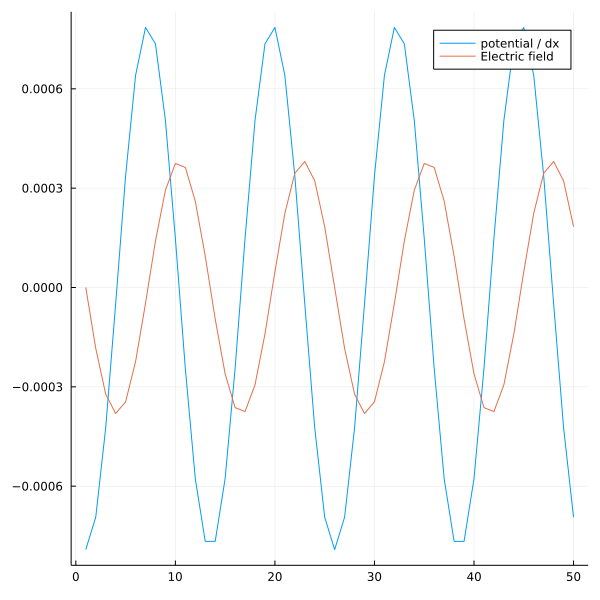

In [58]:
u = zeros(Nx,Np+1)

for i in 1:Nx
    x = get_x(i,dx)
    for j in 1:Np
        p = get_p(j,dp)
        u[i,j] = rel_dist(p,θ = θ) * (1. + α *cos(k*x))
    end
end

#we now normalize it. 

get_density!(u, ρ, (Nx, dx, Np, dp, m))

plot(ρ)

n0 = get_total_density!(ρ,(Nx, dx))

u = u/n0 # now the distribution function is normalized so that its total integral is one. 

println(n0)
println(sum(ρ .- n0))

get_density!(u, ρ, (Nx, dx, Np, dp, m))
n0 = get_total_density!(ρ,(Nx, dx))

println(n0)
println(sum(ρ .- n0))

get_current!(u, S, (Nx, dx, Np, dp, m));

plot!(S)

get_ϕ!(ϕ, ρ .-n0, κ);

E = view(u,:,Np+1)
get_E_from_ϕ!(ϕ, E,dx)

println(sum(ϕ))
plot(ϕ./dx, label="potential / dx")
plot!(E, label="Electric field")

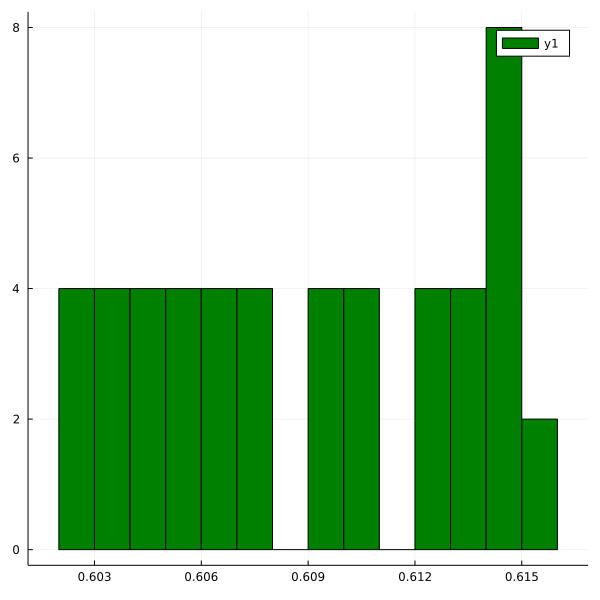

In [59]:
#plot(S)
histogram(S, bins=20)

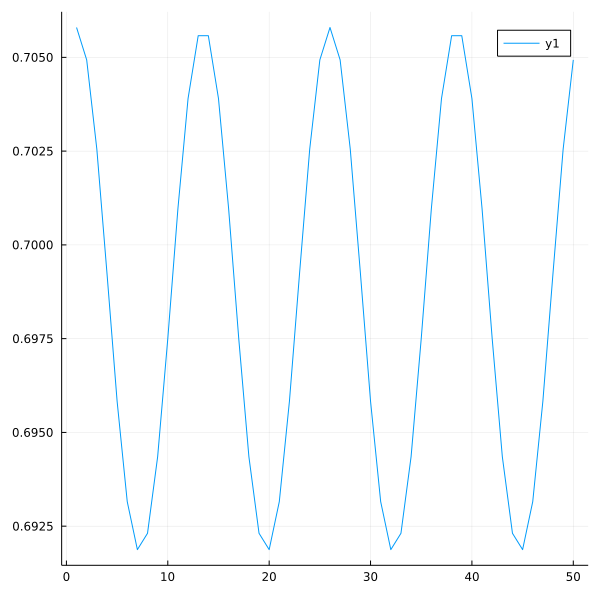

In [60]:
plot(get_K_energy!(u,E_K,(Nx, dx, Np, dp)))

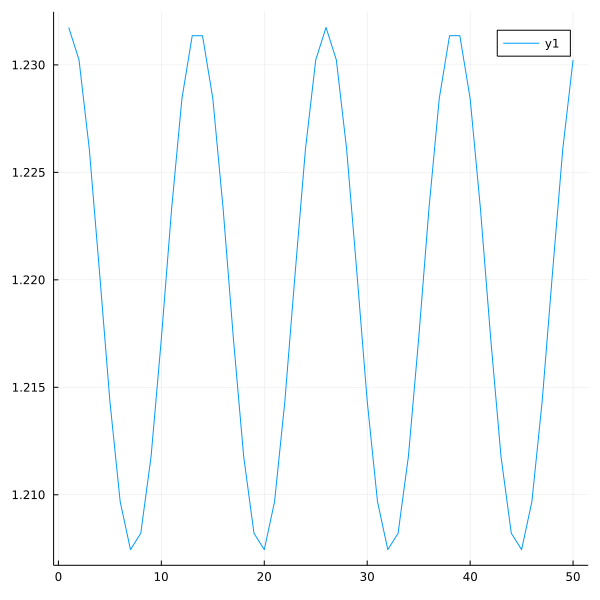

In [61]:
plot(get_momentum!(u,P,(Nx, dx, Np, dp)))

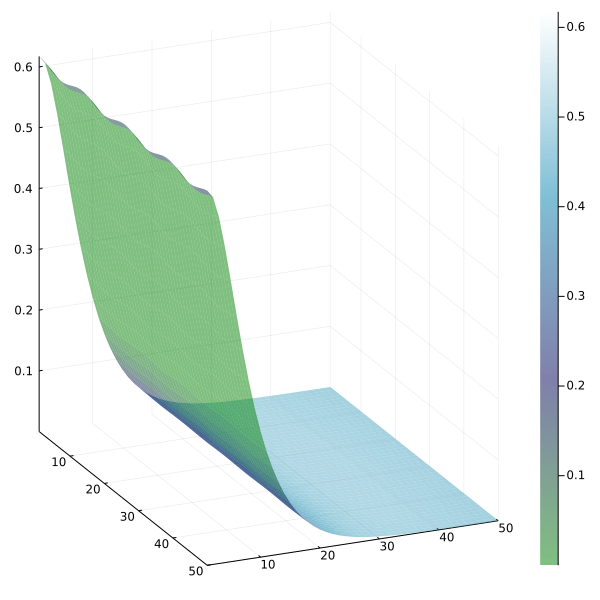

In [62]:
default(size=(600,600)
#, fc=:thermal
#, fc=:heat
, fc=:ocean
)
x, y = 1:Nx, 1:Np
z = Surface((x,y)->u[x,y], x, y)
surface(x,y,z, linealpha = 0.3, fillalpha=0.5, display_option=Plots.GR.OPTION_SHADED_MESH, camera=(60,40))
#plot(u[:,1:Np])

In [65]:
function F!(du,u,p_F)
    dx, dp, Nx, Np, S = p_F 
    par_Dx = Nx, du
    par_Dp = Np, du
    get_current!(u,S,par)
    for j ∈ 1:Np
        p = (j-1)*dp
        du[1:Nx,j] = p * Dc2x(u[1:Nx,j], dx, par_Dx)
    end
    for i ∈ 1:Nx
        du[i,1:Np] =  u[i,Np+1] * D2p_SBP(u[i,1:Np],dp,par_Dp) 
        du[i,Np+1] = -4π * S[i]
    end
    return du
end


F! (generic function with 1 method)

In [66]:
t = 0.0
t_i = 0.0
t_f = 4.0
M = 401
M_g = 400 + 1 #number of outputs, starting from the initial data
dt = t_f / (M-1)


0.01

In [67]:
p_F = dx, dp, Nx, Np, S  

# total quantities 
Energy_K = zeros(M_g)
Energy_E = zeros(M_g)
EField_T = zeros(M_g)
p_T = zeros(M_g)
n_T = zeros(M_g)
S_T = zeros(M_g)
E_E = 0.0
#T = zeros(M_g)

Energy_K[1]  = sum(get_K_energy!(u,E_K,(Nx, dx, Np, dp)))
Energy_E[1]  = get_E_energy!(u,E_E,(Nx, dx))
EField_T[1] = sum(u[:,Np+1])
p_T[1] = sum(get_momentum!(u,P,(Nx, dx, Np, dp)))

get_density!(u, ρ, (Nx, dx, Np, dp, m))
get_current!(u, S, (Nx, dx, Np, dp, m))
n_T[1] = get_total_density!(ρ,(Nx, dx))
S_T[1] = sum(S)/n0/Nx
#T[1] = var(u[N+1:2N])

0.6090247785525895

# hasta aquí llegué

In [ ]:
if nthreads() > 1
    TS = zeros(J, nthreads())
    p_RHSC = (N, J, L, dx, order, n, S, du, get_density!, get_current_threads!, Interpolate_2, TS) ;
    else
    p_RHSC = (N, J, L, dx, order, n, S, du, get_density!, get_current!, Interpolate_2) ;
    end
    
    Energy_K = zeros(M_g)
    Energy_E = zeros(M_g)
    E_T = zeros(M_g)
    v_T = zeros(M_g)
    D_T = zeros(M_g)
    S_T = zeros(M_g)
    T = zeros(M_g)
    if animation
    par = zeros(M_g,2N)
    end
    Energy_K[1], Energy_E[1]  = get_energy(u,(L, N, J))
    E_T[1] = sum(u[2N+1:end])
    v_T[1] = sum(u[N+1:2N])
    get_density!(u, n, p)
    get_current!(u, S, p)
    D_T[1] = sum(n)/n0/J - 1
    S_T[1] = sum(S)/n0/J
    T[1] = var(u[N+1:2N])
    if animation
    par[1,:] = u[1:2N]
    end

In [ ]:


ODEproblem(RK4, f, y0, intervalo, M,p)

